In [1]:
import os
import argparse
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import string

2024-10-03 05:09:27.146851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 05:09:27.164144: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 05:09:27.169410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 05:09:27.182748: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Параметры
IMG_HEIGHT = 64         # Высота изображения
IMG_WIDTH = 256         # Ширина изображения
BATCH_SIZE = 4
MAX_LABEL_LENGTH = 15   # Максимальная длина текста
MARGIN = 0            # Отступ вокруг текста
BG_COLOR = 'white'      # Цвет фона
TEXT_COLOR = 'black'    # Цвет текста

# Пути к директориям
FONT_DIR = 'text/fonts/'
TEXT_FILE = 'text/sah.wordlist'
OUTPUT_IMAGE_DIR = 'test_images/images'
OUTPUT_LABEL_DIR = 'test_images/labels'
FONTS_LIST_FILE = 'text/okfonts_test.txt'

In [3]:
def load_texts(text_file):
    with open(text_file, 'r', encoding='utf-8') as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

texts = load_texts(TEXT_FILE)[:1000]
print(f"Всего слов для генерации: {len(texts)}")

Всего слов для генерации: 1000


In [4]:
with open(FONTS_LIST_FILE, 'r', encoding='utf-8') as f:
    font_dir_names = [line.strip() for line in f if line.strip()]
    
fonts = []

for font_dir_name in font_dir_names:
    font_dir_path = os.path.join(FONT_DIR, font_dir_name)
    if not os.path.isdir(font_dir_path):
        print(f"Директория {font_dir_path} не найдена. Пропускаем её.")
        continue
    for root, dirs, files in os.walk(font_dir_path):
        for fname in files:
            if fname.lower().endswith(('.ttf', '.otf')):
                font_path = os.path.join(root, fname)
                fonts.append(font_path)

print(f"Количество найденных файлов шрифтов: {len(fonts)}")

Количество найденных файлов шрифтов: 75


In [27]:
# Генерация Изображений и Меток
def create_image(text, font_path, img_height, img_width, margin, bg_color, text_color):
    try:
        font_size = 32  # Начальный размер шрифта
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Не удалось загрузить шрифт: {font_path}")
        return None

    # Создаём изображение с фоном
    image = Image.new('RGB', (img_width, img_height), color=bg_color)
    draw = ImageDraw.Draw(image)

    # Автоматически подбираем размер шрифта
    while True:
        # Используем textbbox вместо textsize
        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]
        
        if text_width + 2 * margin < img_width and text_height + 2 * margin < img_height:
            break
        font_size -= 1
        if font_size <= 10:
            break
        try:
            font = ImageFont.truetype(font_path, font_size)
        except IOError:
            print(f"Не удалось загрузить шрифт: {font_path} с размером {font_size}")
            return None

    # Позиционирование текста по центру
    x = (img_width - text_width) / 2
    y = (img_height - text_height) / 2

    draw.text((x, y), text, font=font, fill=text_color)

    # Преобразуем в массив NumPy
    image = np.array(image)

    # Дополнительная обработка (например, бинаризация)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    image = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)

    return image

In [28]:
# Генерация изображений и меток
for font_path in tqdm(fonts, desc="Шрифты"):
    font_name = os.path.splitext(os.path.basename(font_path))[0]
    for idx, line in enumerate(tqdm(texts, desc=f"Генерация для шрифта {font_name}", leave=False)):
        # Создаём изображение
        image = create_image(
            text=line,
            font_path=font_path,
            img_height=IMG_HEIGHT,
            img_width=IMG_WIDTH,
            margin=MARGIN,
            bg_color=BG_COLOR,
            text_color=TEXT_COLOR
        )
        if image is None:
            continue

        # Формируем имена файлов
        image_filename = f"img_{font_name}_{idx}.png"
        label_filename = f"img_{font_name}_{idx}.txt"

        # Сохраняем изображение
        image_path = os.path.join(OUTPUT_IMAGE_DIR, image_filename)
        cv2.imwrite(image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

        # Сохраняем метку
        label_path = os.path.join(OUTPUT_LABEL_DIR, label_filename)
        with open(label_path, 'w', encoding='utf-8') as label_file:
            label_file.write(line)

print("Генерация датасета завершена.")

Шрифты:  17%|█▋        | 13/75 [00:55<04:22,  4.23s/it]                                      
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   0%|          | 0/1000 [00:00<?, ?it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   3%|▎         | 31/1000 [00:00<00:03, 307.88it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   6%|▌         | 62/1000 [00:00<00:03, 288.36it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:   9%|▉         | 91/1000 [00:00<00:03, 252.13it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  12%|█▏        | 117/1000 [00:00<00:03, 226.17it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  14%|█▍        | 141/1000 [00:00<00:04, 195.43it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  16%|█▌        | 162/1000 [00:00<00:04, 184.53it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  18%|█▊        | 181/1000 [00:00<00:04, 177.49it/s]
Генерация для шрифта AlegreyaSans-ExtraBoldItalic:  20%|██        | 202/1000 [00:00<00:04, 185.8

Генерация датасета завершена.


In [22]:
import glob
from sklearn.model_selection import train_test_split

In [23]:
# Создание списков путей к изображениям и меткам
def get_image_label_pairs(image_dir, label_dir):
    image_files = sorted(glob.glob(os.path.join(image_dir, '*.png')))
    label_files = sorted(glob.glob(os.path.join(label_dir, '*.txt')))
    image_label_pairs = []
    for img_path, lbl_path in zip(image_files, label_files):
        with open(lbl_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()
        # Преобразуем текст в числовые метки
        label_seq = text_to_labels(label)
        if len(label_seq) > 0:  # Фильтруем метки с длиной > 0
            image_label_pairs.append((img_path, label))
    return image_label_pairs

In [24]:
image_label_pairs = get_image_label_pairs(OUTPUT_IMAGE_DIR, OUTPUT_LABEL_DIR)
print(f"Всего пар изображение-метка: {len(image_label_pairs)}")
# Ожидаемый вывод: Всего пар изображение-метка: 1000 * количество шрифтов

# Разделение данных на обучающую, валидационную и тестовую выборки
train_pairs, temp_pairs = train_test_split(image_label_pairs, test_size=0.2, random_state=42)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

print(f"Train: {len(train_pairs)}, Validation: {len(val_pairs)}, Test: {len(test_pairs)}")

Всего пар изображение-метка: 75000
Train: 60000, Validation: 7500, Test: 7500


In [25]:
for batch in train_dataset.take(1):
    inputs, _ = batch
    print("input_image shape:", inputs['input_image'].shape)      # (batch_size, 64, 256, 3)
    print("labels shape:", inputs['labels'].shape)                # (batch_size, 15)
    print("input_length shape:", inputs['input_length'].shape)    # (batch_size, 1)
    print("label_length shape:", inputs['label_length'].shape)    # (batch_size, 1)
    print("input_length dtype:", inputs['input_length'].dtype)    # int32
    print("label_length dtype:", inputs['label_length'].dtype)    # int32
    break

input_image shape: (4, 64, 256, 3)
labels shape: (4, 15)
input_length shape: (4, 1)
label_length shape: (4, 1)
input_length dtype: <dtype: 'int32'>
label_length dtype: <dtype: 'int32'>


In [26]:
def preprocess_image(image_path, img_height, img_width):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0  # Нормализация
    return img.astype(np.float32)

def encode_sample(image_path, label):
    # Декодируем image_path и label из байтов в строки
    image_path = image_path.numpy().decode('utf-8')
    label = label.numpy().decode('utf-8')
    
    # Обрабатываем изображение
    img = preprocess_image(image_path, IMG_HEIGHT, IMG_WIDTH)
    
    # Преобразуем текст в числовые метки
    label = text_to_labels(label)
    
    # Обрезаем и дополняем метку до MAX_LABEL_LENGTH
    if len(label) > MAX_LABEL_LENGTH:
        label = label[:MAX_LABEL_LENGTH]
    else:
        label += [0] * (MAX_LABEL_LENGTH - len(label))
    
    # Преобразуем в numpy массив и обеспечиваем правильную форму
    label = np.array(label, dtype=np.int32).reshape(MAX_LABEL_LENGTH,)
    
    # Проверка длины метки
    assert len(label) == MAX_LABEL_LENGTH, f"Label length {len(label)} != MAX_LABEL_LENGTH {MAX_LABEL_LENGTH}"
    
    return img, label

def tf_encode(image_path, label):
    img, label = tf.py_function(
        func=encode_sample, 
        inp=[image_path, label], 
        Tout=[tf.float32, tf.int32]
    )
    img.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    label.set_shape([MAX_LABEL_LENGTH])
    return img, label


def prepare_dataset(pairs):
    image_paths, labels = zip(*pairs)
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))
    dataset = dataset.map(tf_encode, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [79]:
# Подготовка Словаря Символов
characters = string.ascii_letters + string.digits + 'абвгдеёжзийклмнопрстуфхцчшщъыьэюяҕҥөһүАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯҔҤӨҺҮ '

# Создание маппинга символов в числа и обратно
char_to_num = {char: idx + 1 for idx, char in enumerate(characters)}  # 0 для CTC blank
num_to_char = {idx + 1: char for idx, char in enumerate(characters)}

def text_to_labels(text):
    return [char_to_num[char] for char in text if char in char_to_num]

def labels_to_text(labels):
    return ''.join([num_to_char[label] for label in labels if label in num_to_char])

In [28]:
train_dataset = prepare_dataset(train_pairs)
val_dataset = prepare_dataset(val_pairs)
test_dataset = prepare_dataset(test_pairs)

In [29]:
def prepare_batch(images, labels):
    # Считаем количество ненулевых элементов в каждой метке и устанавливаем dtype=int32
    label_length = tf.math.count_nonzero(labels, axis=1, dtype=tf.int32)
    
    # Добавляем размерность, чтобы получить форму (batch_size, 1)
    label_length = tf.expand_dims(label_length, axis=1)
    
    # Устанавливаем длину входа в соответствии с моделью и добавляем размерность (batch_size, 1)
    input_length = tf.ones(shape=(tf.shape(labels)[0], 1), dtype=tf.int32) * (IMG_WIDTH // 8)  # Примерное значение, зависит от модели
    
    return {
        "input_image": images,
        "labels": labels,
        "input_length": input_length,
        "label_length": label_length
    }, None


In [30]:
# Применение batch, map и prefetch
train_dataset = train_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).map(prepare_batch, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [31]:
from tensorflow.keras import layers, models

In [32]:
def build_crnn_model(img_width, img_height, num_chars):
    input_image = layers.Input(shape=(img_height, img_width, 3), name='input_image')

    # CNN Backbone
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(input_image)
    x = layers.MaxPooling2D((2,2))(x)  # (img_height/2, img_width/2, 64)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)  # (img_height/4, img_width/4, 128)

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((1,2))(x)  # (img_height/4, img_width/8, 256)

    # Reshape для RNN
    new_shape = (img_width // 8, (img_height // 4) * 256)
    x = layers.Reshape(target_shape=new_shape)(x)  # (batch_size, img_width/8, img_height/4 * 256)

    # RNN
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)

    # Выходной слой
    y_pred = layers.Dense(num_chars + 1, activation='softmax')(x)  # +1 для CTC blank

    crnn_model = models.Model(inputs=input_image, outputs=y_pred, name='crnn_model')
    return crnn_model

# Создание модели
num_chars = len(char_to_num)
crnn_model = build_crnn_model(IMG_WIDTH, IMG_HEIGHT, num_chars)
crnn_model.summary()

Model: "crnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 64, 256, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 256, 64)    │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 4096)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 256)        │     4,326,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 32, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32, 140)        │        35,980 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,718,540 (21.81 MB)

 Trainable params: 5,718,028 (21.81 MB)

 Non-trainable params: 512 (2.00 KB)

In [33]:
class CRNNWithCTCLoss(tf.keras.Model):
    def __init__(self, crnn, **kwargs):
        super(CRNNWithCTCLoss, self).__init__(**kwargs)
        self.crnn = crnn
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self, data):
        # Распаковка данных: inputs_dict и targets (которые равны None)
        inputs, _ = data
        input_image = inputs['input_image']
        labels = inputs['labels']
        input_length = inputs['input_length']
        label_length = inputs['label_length']
        
        with tf.GradientTape() as tape:
            # Получение предсказаний от модели
            y_pred = self.crnn(input_image, training=True)
            # Вычисление CTC потерь
            loss = tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
            loss = tf.reduce_mean(loss)
        
        # Вычисление градиентов
        gradients = tape.gradient(loss, self.crnn.trainable_variables)
        # Применение градиентов
        self.optimizer.apply_gradients(zip(gradients, self.crnn.trainable_variables))
        # Обновление метрики потерь
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}
    
    def test_step(self, data):
        # Распаковка данных: inputs_dict и targets (которые равны None)
        inputs, _ = data
        input_image = inputs['input_image']
        labels = inputs['labels']
        input_length = inputs['input_length']
        label_length = inputs['label_length']
        
        # Получение предсказаний от модели
        y_pred = self.crnn(input_image, training=False)
        # Вычисление CTC потерь
        loss = tf.keras.backend.ctc_batch_cost(labels, y_pred, input_length, label_length)
        loss = tf.reduce_mean(loss)
        # Обновление метрики потерь
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


In [34]:
full_model = CRNNWithCTCLoss(crnn_model)

full_model.compile(optimizer='adam')

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

In [36]:
checkpoint = ModelCheckpoint('ocr_crnn_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
tensorboard = TensorBoard(log_dir='logs')

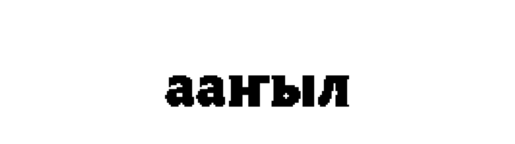

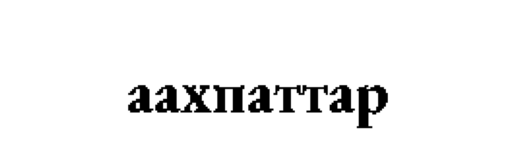

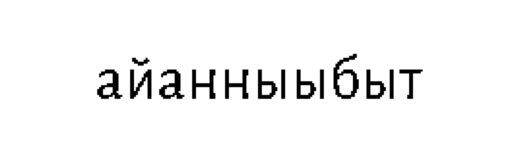

2024-10-03 05:24:27.179091: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [37]:
def display_samples(dataset, num_samples=5):
    for batch in dataset.take(1):
        inputs, _ = batch
        images = inputs['input_image'].numpy()
        labels = inputs['labels'].numpy()
        for i in range(min(num_samples, images.shape[0])):
            plt.imshow(images[i])
            plt.axis('off')
            plt.show()

# Визуализация обучающей выборки
display_samples(train_dataset, num_samples=3)

In [39]:
# Обучение модели
history = full_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[checkpoint, early_stop, tensorboard]
)

Epoch 1/100


W0000 00:00:1727933079.028492    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.029214    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.029771    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.030343    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.032239    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.032806    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.033444    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.034027    2160 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933079.034585    2160 gp

14999/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 20.9973

W0000 00:00:1727933429.481343    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.486745    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.487319    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.487972    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.488543    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.489138    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.489688    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.490186    2158 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727933429.490832    2158 gp


Epoch 1: val_loss improved from inf to 21.70062, saving model to ocr_crnn_model.keras


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py:102: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


15000/15000 ━━━━━━━━━━━━━━━━━━━━ 369s 24ms/step - loss: 20.9972 - val_loss: 21.7006
Epoch 2/100
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 19.3651
Epoch 2: val_loss improved from 21.70062 to 19.09150, saving model to ocr_crnn_model.keras
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 369s 25ms/step - loss: 19.3651 - val_loss: 19.0915
Epoch 3/100
14998/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 19.0933
Epoch 3: val_loss did not improve from 19.09150
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 366s 24ms/step - loss: 19.0933 - val_loss: 19.1185
Epoch 4/100
14998/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 18.9436
Epoch 4: val_loss improved from 19.09150 to 18.95756, saving model to ocr_crnn_model.keras
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 364s 24ms/step - loss: 18.9436 - val_loss: 18.9576
Epoch 5/100
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 18.7952
Epoch 5: val_loss did not improve from 18.95756
15000/15000 ━━━━━━━━━━━━━━━━━━━━ 366s 24ms/step - loss: 18.7952 - val_loss: 19.0696
Epoch 

KeyboardInterrupt: 

In [68]:
crnn_model = full_model.crnn

# Загрузка CRNN модели
crnn_model.save('crnn_model.keras')

In [70]:
# Загрузка CRNN модели
crnn_model = tf.keras.models.load_model('crnn_model.keras')

In [74]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import string
import random
from tensorflow.keras import backend as K

In [82]:
def decode_predictions(pred):
    input_length = np.ones(pred.shape[0]) * pred.shape[1]
    
    decoded, log_prob = tf.keras.backend.ctc_decode(pred, input_length=input_length, greedy=True)
    decoded_sequences = tf.keras.backend.get_value(decoded[0])
    
    decoded_texts = []
    for seq in decoded_sequences:
        text = ''.join([num_to_char.get(i, '') for i in seq if i != -1])
        decoded_texts.append(text)
    return decoded_texts

def display_image_with_text(image, actual_text, predicted_text):
    plt.figure(figsize=(8, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Фактический текст: {actual_text}\nПредсказанный текст: {predicted_text}", fontsize=14)
    plt.show()

def preprocess_image(image_path, img_height=64, img_width=256):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0
    
    return img.astype(np.float32)

In [83]:
def predict_and_display(crnn_model, test_pairs, num_samples=5):
    samples = random.sample(test_pairs, num_samples)
    
    for image_path, actual_label in samples:
        print(f"Фактический текст: {actual_label}")
        
        img = preprocess_image(image_path)
        
        input_image = np.expand_dims(img, axis=0)  # Форма: (1, 64, 256, 3)
        
        y_pred = crnn_model.predict(input_image)

        decoded_texts = decode_predictions(y_pred)
        predicted_text = decoded_texts[0]
        print(f"Предсказанный текст: {predicted_text}")
        
        display_img = (img * 255).astype(np.uint8)
        
        display_image_with_text(display_img, actual_label, predicted_text)

In [84]:
crnn_model = tf.keras.models.load_model('crnn_model.keras')

In [88]:
import os

TEST_IMAGE_DIR = 'test_images/images'  # Замените на ваш путь к тестовым изображениям
TEST_LABEL_DIR = 'test_images/labels'  # Замените на ваш путь к файлам с метками

def load_test_pairs(image_dir, label_dir):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    
    test_pairs = []
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)
        
        with open(lbl_path, 'r', encoding='utf-8') as f:
            label = f.read().strip()
        
        test_pairs.append((img_path, label))
    
    return test_pairs

In [89]:
# Загрузка тестовых пар
test_pairs = load_test_pairs(TEST_IMAGE_DIR, TEST_LABEL_DIR)
print(f"Всего тестовых пар: {len(test_pairs)}")

Всего тестовых пар: 75000


Фактический текст: алампаҕа
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


W0000 00:00:1727943134.685750    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.686858    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.687406    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.687922    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.688468    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.689054    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.689685    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.690324    2162 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1727943134.690940    2162 gp

Предсказанный текст: аааата


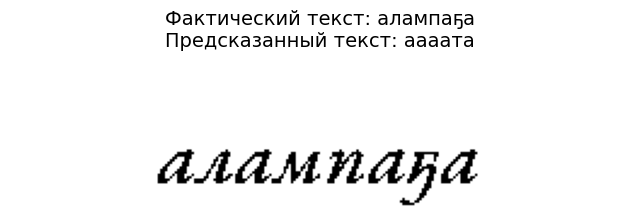

Фактический текст: ал
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предсказанный текст: ааа


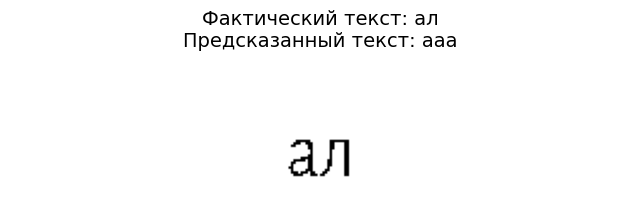

Фактический текст: абуталиб
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предсказанный текст: айаана


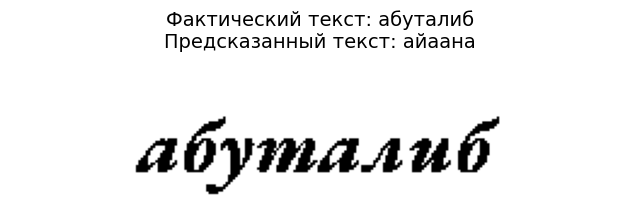

Фактический текст: ааҕардааҕар
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Предсказанный текст: ааааба


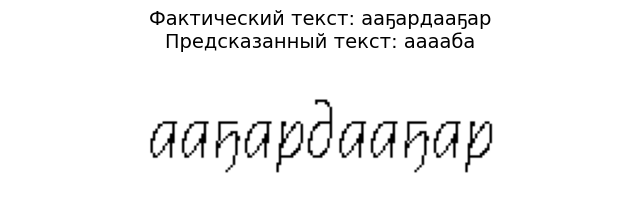

Фактический текст: абдалкаримдиэн
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Предсказанный текст: айыытата


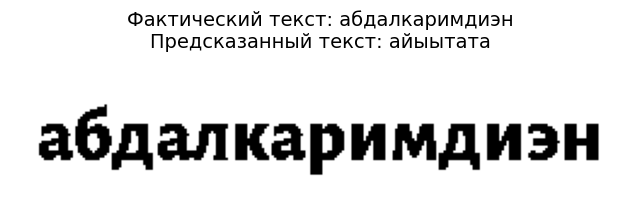

In [90]:
predict_and_display(crnn_model, test_pairs, num_samples=5)